<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/images/interpretability_activations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
!pip install -q torchvision
!pip install -q pillow

Activations that produce the final classification of the image can be mapped to see which part of the image resulted in the provided label.

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import EuroSAT
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = './eurosat'
dataset = EuroSAT(root=root, transform=transform, download=True)

#split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x,  return_features=False):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)
        if return_features:
            return x
        x = self.fc(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(dataset.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Finished Training")

Epoch [1/15], Loss: 0.6536
Epoch [2/15], Loss: 0.2487
Epoch [3/15], Loss: 0.6992
Epoch [4/15], Loss: 0.7149
Epoch [5/15], Loss: 0.5381
Epoch [6/15], Loss: 0.3118
Epoch [7/15], Loss: 0.0989
Epoch [8/15], Loss: 0.2258
Epoch [9/15], Loss: 0.2124
Epoch [10/15], Loss: 0.0588
Epoch [11/15], Loss: 0.0465
Epoch [12/15], Loss: 0.1658
Epoch [13/15], Loss: 0.0496
Epoch [14/15], Loss: 0.0604
Epoch [15/15], Loss: 0.1289
Finished Training


Grad-CAM uses the gradient-weighted feature maps, where the gradients of the class score with respect to the feature maps are used to weight the feature maps, and then these weighted feature maps are summed to form the final heatmap.

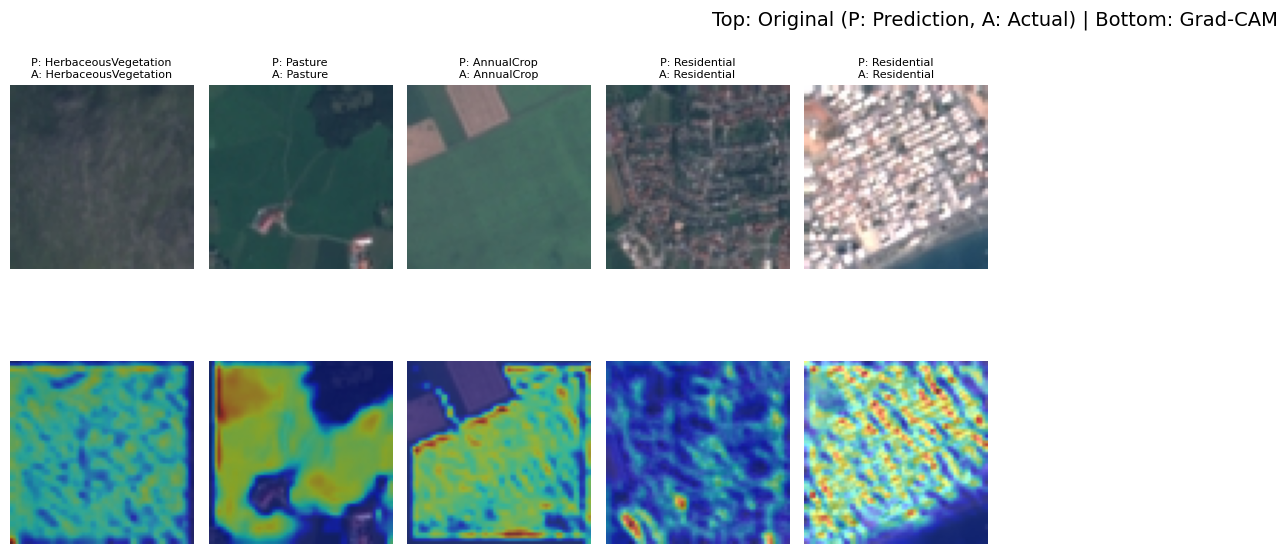

In [58]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class_names = test_dataset.dataset.classes
device = next(model.parameters()).device

images, targets = next(iter(test_loader))
images = images.to(device)
targets = targets.to(device)

feature_maps = []
gradients = []

def save_feature_maps(module, input, output):
    feature_maps.append(output)

def save_gradients(module, grad_input, grad_output):
    gradients.append(grad_output[0])

_ = model.conv2.register_forward_hook(save_feature_maps)
_ = model.conv2.register_backward_hook(save_gradients)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

plt.figure(figsize=(20, 6))

for i in range(5):
    feature_maps.clear()
    gradients.clear()

    input_tensor = images[i].unsqueeze(0)  # (1, 3, H, W)
    output = model(input_tensor)

    pred_class = output.argmax(dim=1).item()
    true_class = targets[i].item()

    # Backward for Grad-CAM
    model.zero_grad()
    output[0, pred_class].backward()

    # Grad-CAM computation
    fmap = feature_maps[0]
    grads = gradients[0]
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * fmap).sum(dim=1).squeeze()
    cam = F.relu(cam)

    cam_resized = F.interpolate(
        cam.unsqueeze(0).unsqueeze(0),
        size=(input_tensor.shape[2], input_tensor.shape[3]),
        mode='bilinear',
        align_corners=False
    ).squeeze().cpu().detach().numpy()

    # De-normalize image
    img = images[i].detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Original image with predicted/actual labels
    plt.subplot(2, 10, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"P: {class_names[pred_class]}\nA: {class_names[true_class]}", fontsize=8)

    # Grad-CAM overlay
    plt.subplot(2, 10, i + 11)
    plt.imshow(img)
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.axis("off")

plt.suptitle("Top: Original (P: Prediction, A: Actual) | Bottom: Grad-CAM", fontsize=14)
plt.tight_layout()
plt.show()


Class Activation Maps (CAM) using Global Average Pooling (GAP) with a minimal script, we’ll focus on extracting feature maps from a convolutional layer, applying GAP to compute channel weights, and creating a 2D CAM for visualization.

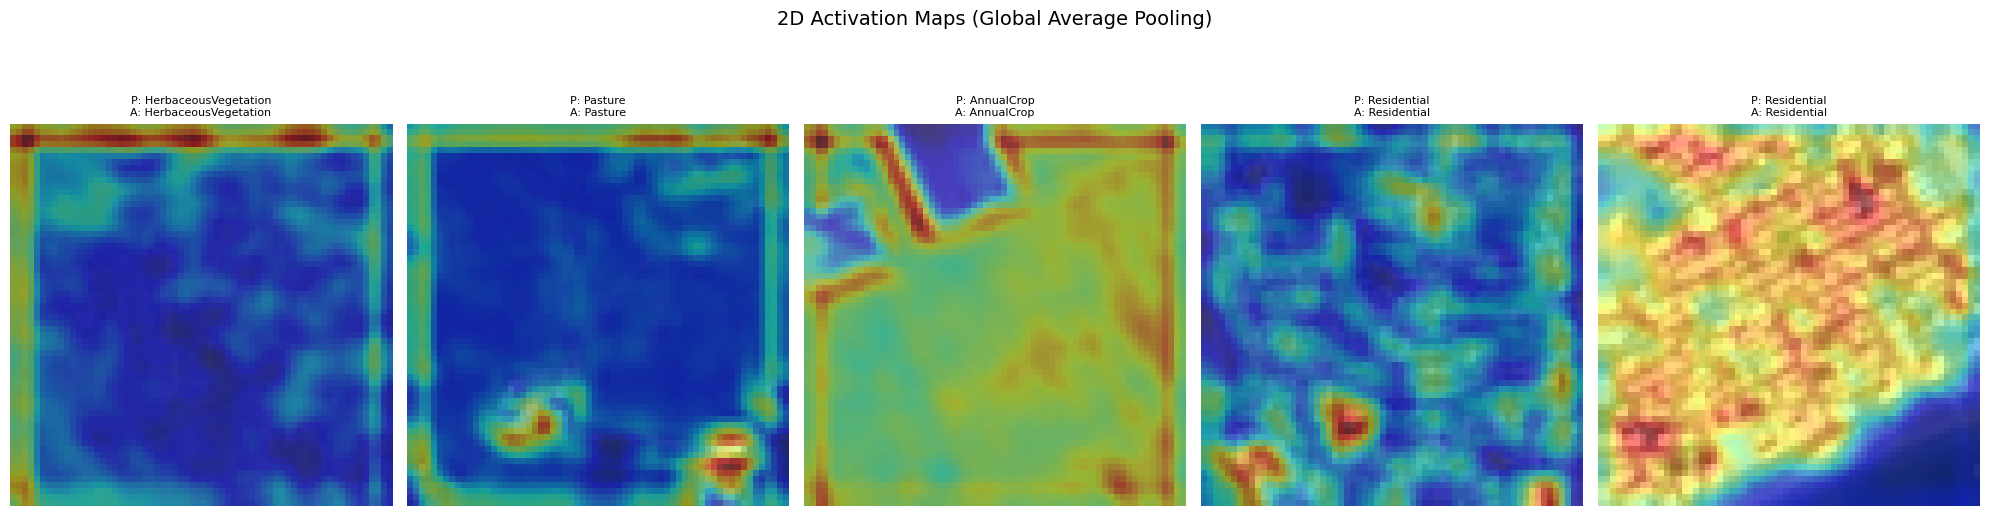

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assume model, test_loader, and test_dataset are defined
class_names = test_dataset.dataset.classes
device = next(model.parameters()).device

# Load a batch from test_loader
images, targets = next(iter(test_loader))
images = images.to(device)
targets = targets.to(device)

# Store feature maps
feature_maps = []

def save_feature_maps(module, input, output):
    feature_maps.append(output.detach())

# Register hook on the conv2 layer
if hasattr(model, 'conv2'):
    _ = model.conv2.register_forward_hook(save_feature_maps)
else:
    raise AttributeError("Model does not have 'conv2' layer")

# CIFAR-10 normalization constants
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Plot setup
plt.figure(figsize=(20, 6))

# Loop through the first 5 images
for i in range(min(5, images.size(0))):
    feature_maps.clear()

    # Forward pass for a single image
    input_tensor = images[i].unsqueeze(0)  # (1, 3, H, W)
    with torch.no_grad():
        output = model(input_tensor)

    # Get predicted and true class labels
    pred_class = output.argmax(dim=1).item()
    true_class = targets[i].item()

    # Get feature maps from conv2
    fmap = feature_maps[0]  # Shape: (1, C, H', W')
    fmap = fmap.squeeze(0)  # Shape: (C, H', W')

    # Apply Global Average Pooling to get weights
    gap_weights = F.avg_pool2d(fmap, fmap.size()[1:]).squeeze()  # Shape: (C)

    # Compute 2D activation map as weighted sum of feature maps
    activation_map = torch.einsum('c,chw->hw', gap_weights, fmap).cpu().numpy()  # Shape: (H', W')

    # Resize to input image size
    activation_map = F.interpolate(
        torch.from_numpy(activation_map).unsqueeze(0).unsqueeze(0),
        size=images[i].shape[1:],
        mode='bilinear',
        align_corners=False
    ).squeeze().numpy()

    # Normalize activation map
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)

    # Denormalize image
    img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Plot original image with activation map overlay
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.imshow(activation_map, cmap='jet', alpha=0.5)
    plt.axis("off")
    plt.title(f"P: {class_names[pred_class]}\nA: {class_names[true_class]}", fontsize=8)

plt.suptitle("2D Activation Maps (Global Average Pooling)", fontsize=14)
plt.tight_layout()
plt.show()